# Part Load Modeling

## Introduction

- why partload modeling -> ambient temperature vs. compressor power (pressure ratio/mass flow)
- table/figures with part load modeling assumptions (operational boundaries, characteristic functions)

## Preparing the model

In [1]:
from tespy.components import Condenser, HeatExchanger, CycleCloser, Compressor, Valve, Source, Sink
from tespy.connections import Connection, Ref
from tespy.networks import Network

wf = "R290"
nwk = Network(fluids=[wf, "air", "Water"], p_unit="bar", T_unit="C", iterinfo=False)

cp = Compressor("compressor")
ev = HeatExchanger("evaporator")
cd = Condenser("condenser")
va = Valve("expansion valve")
cc = CycleCloser("cycle closer")

so1 = Source("ambient air source")
si1 = Sink("ambient air sink")
so2 = Source("heating source")
si2 = Sink("heating sink")

c0 = Connection(va, "out1", cc, "in1", label="0")
c1 = Connection(cc, "out1", ev, "in2", label="1")
c2 = Connection(ev, "out2", cp, "in1", label="2")
c3 = Connection(cp, "out1", cd, "in1", label="3")
c4 = Connection(cd, "out1", va, "in1", label="4")

nwk.add_conns(c0, c1, c2, c3, c4)

c11 = Connection(so1, "out1", ev, "in1", label="11")
c12 = Connection(ev, "out1", si1, "in1", label="12")

c21 = Connection(so2, "out1", cd, "in2", label="21")
c22 = Connection(cd, "out2", si2, "in1", label="22")

nwk.add_conns(c11, c12, c21, c22)

# connections
# c2.set_attr(T=-5)
c4.set_attr(T=55)

# components
Q_design = -10e3
cp.set_attr(eta_s=0.8)
cd.set_attr(Q=Q_design)

# connections
c2.set_attr(fluid={wf: 1, "Water": 0, "air": 0}, x=1.0)
c11.set_attr(fluid={wf: 0, "Water": 0, "air": 1}, p=1.0, T=5)
c12.set_attr(T=Ref(c11, 1, -2))
c21.set_attr(fluid={wf: 0, "Water": 1, "air": 0}, p=3.0, T=40)
c22.set_attr(T=50)

# components
cd.set_attr(pr1=1, pr2=1)
ev.set_attr(pr1=1, pr2=1, ttd_l=5)

nwk.solve("design")

cd.set_attr(ttd_u=5)
c4.set_attr(T=None)

nwk.solve("design")

nwk.print_results(colored=False)
nwk.save("design-state")
nwk.save("tmp")

##### RESULTS (HeatExchanger) #####
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|            |         Q |       kA |   td_log |    ttd_u |    ttd_l |      pr1 |      pr2 |    zeta1 |    zeta2 |
|------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------|
| evaporator | -7.22e+03 | 1.21e+03 | 5.94e+00 | 7.00e+00 | 5.00e+00 | 1.00e+00 | 1.00e+00 | 0.00e+00 | 1.83e-06 |
+------------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
##### RESULTS (Condenser) #####
+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+
|           |         Q |       kA |   td_log |    ttd_u |    ttd_l |      pr1 |      pr2 |    zeta1 |    zeta2 |
|-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------|
| condenser | -

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


temperature_range = np.linspace(-10, 30, 41)
results_temperature = pd.DataFrame(
    index=temperature_range,
    columns=["compressor-power", "pressure-ratio", "wf-massflow", "COP"]
)

for temperature in temperature_range:

    c11.set_attr(T=temperature)
    nwk.solve("design")

    results_temperature.loc[temperature, "compressor-power"] = cp.P.val
    results_temperature.loc[temperature, "pressure-ratio"] = cp.pr.val
    results_temperature.loc[temperature, "wf-massflow"] = c1.m.val
    results_temperature.loc[temperature, "COP"] = abs(cd.Q.val) / cp.P.val

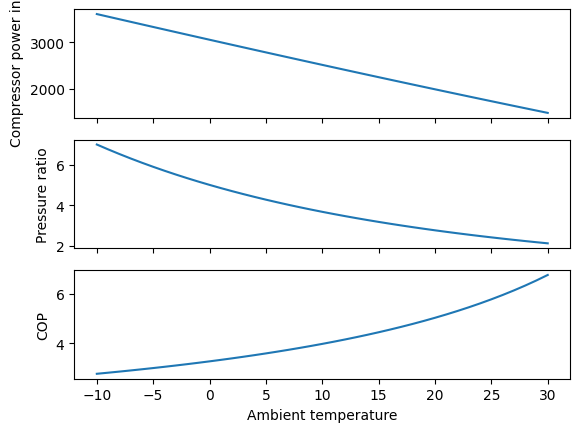

In [3]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(temperature_range, results_temperature["compressor-power"])
ax[1].plot(temperature_range, results_temperature["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
_ = ax[2].set_xlabel("Ambient temperature")


In [27]:
heat_range = np.linspace(0.5, 1.1, 13) * Q_design
results_heat = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "COP"]
)
T_heat_partload = 20
c11.set_attr(T=T_heat_partload)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("design")

    results_heat.loc[heat, "compressor-power"] = cp.P.val
    results_heat.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

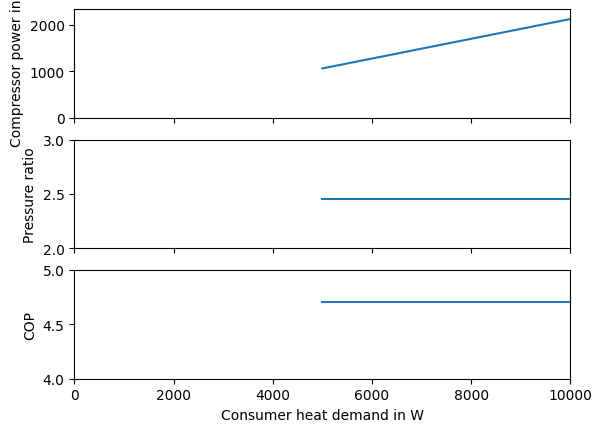

In [31]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"])
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[1].set_ylim([2, 3])
ax[2].set_ylabel("COP")
ax[2].set_ylim([4, 5])
ax[2].set_xlim([0, abs(Q_design)])
_ = ax[2].set_xlabel("Consumer heat demand in W")

In [6]:
cd.set_attr(Q=Q_design)
cp.set_attr(design=["eta_s"], offdesign=["eta_s_char"])
cp.eta_s_char.char_func.extrapolate = True
ev.set_attr(design=["ttd_l"], offdesign=["kA_char"])
cd.set_attr(design=["ttd_u"], offdesign=["kA_char"])
c11.set_attr(offdesign=["m"])
c12.set_attr(design=["T"])

# temperature_range = np.linspace(5, -10, 16)

results_temperature_partload = pd.DataFrame(
    index=temperature_range,
    columns=["compressor-power", "pressure-ratio", "wf-massflow", "COP"]
)


for temperature in temperature_range:

    c11.set_attr(T=temperature)
    nwk.solve("offdesign", design_path="design-state")  

    results_temperature_partload.loc[temperature, "compressor-power"] = cp.P.val
    results_temperature_partload.loc[temperature, "pressure-ratio"] = cp.pr.val
    results_temperature_partload.loc[temperature, "wf-massflow"] = c1.m.val
    results_temperature_partload.loc[temperature, "COP"] = abs(cd.Q.val) / cp.P.val

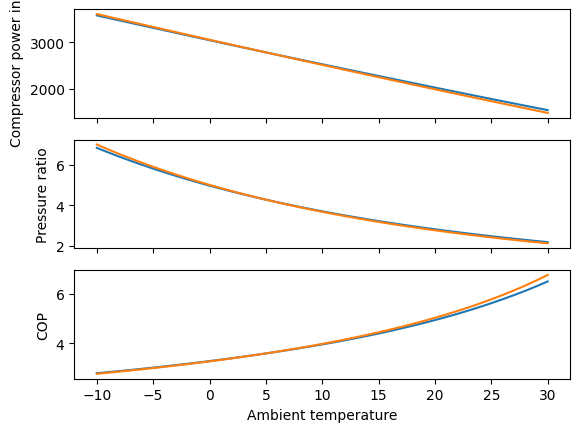

In [7]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(temperature_range, results_temperature_partload["compressor-power"])
ax[1].plot(temperature_range, results_temperature_partload["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature_partload["COP"])

ax[0].plot(temperature_range, results_temperature["compressor-power"])
ax[1].plot(temperature_range, results_temperature["pressure-ratio"])
ax[2].plot(temperature_range, results_temperature["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
_ = ax[2].set_xlabel("Ambient temperature")

In [23]:
c11.set_attr(T=T_heat_partload)
results_heat_partload = pd.DataFrame(
    index=heat_range,
    columns=["compressor-power", "pressure-ratio", "wf-massflow", "COP"]
)

for heat in heat_range[::-1]:
    cd.set_attr(Q=heat)
    nwk.solve("offdesign", design_path="design-state")

    results_heat_partload.loc[heat, "compressor-power"] = cp.P.val
    results_heat_partload.loc[heat, "pressure-ratio"] = cp.pr.val
    results_heat_partload.loc[heat, "wf-massflow"] = c1.m.val
    results_heat_partload.loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val

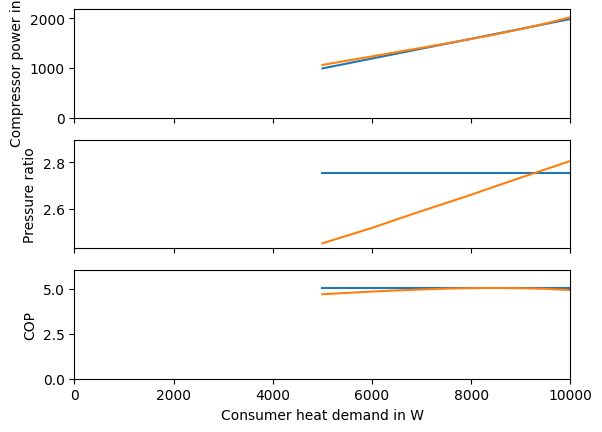

In [24]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(np.abs(heat_range), results_heat["compressor-power"], label="no partload")
ax[1].plot(np.abs(heat_range), results_heat["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat["COP"])
ax[0].plot(np.abs(heat_range), results_heat_partload["compressor-power"], label="partload")
ax[1].plot(np.abs(heat_range), results_heat_partload["pressure-ratio"])
ax[2].plot(np.abs(heat_range), results_heat_partload["COP"])

ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, results_heat["compressor-power"].max()])
ax[1].set_ylabel("Pressure ratio")
ax[2].set_ylabel("COP")
ax[2].set_ylim([0, results_heat_partload["COP"].max() + 1])
ax[2].set_xlim([0, abs(Q_design)])
_ = ax[2].set_xlabel("Consumer heat demand in W")

In [10]:
results_heat_partload["compressor-power"]

-5000.0     1062.628198
-5500.0     1149.804417
-6000.0     1235.034648
-6500.0     1321.450055
-7000.0     1407.438252
-7500.0     1494.138383
-8000.0     1584.621207
-8500.0     1680.867696
-9000.0     1783.897009
-9500.0     1896.268394
-10000.0    2023.687437
-10500.0    2173.104582
-11000.0    2355.563418
Name: compressor-power, dtype: object

In [32]:
results = {}


for temperature in temperature_range:
    results[temperature] = pd.DataFrame(index=heat_range, columns=["COP", "compressor-power"])
    c11.set_attr(T=temperature)
    for heat in heat_range[::-1]:
        cd.set_attr(Q=heat)
        if heat == heat_range[-1]:
            nwk.solve("offdesign", design_path="design-state", init_path="tmp")
            nwk.save("tmp")
        else:
            nwk.solve("offdesign", design_path="design-state")  

        results[temperature].loc[heat, "COP"] = abs(cd.Q.val) / cp.P.val
        results[temperature].loc[heat, "compressor-power"] = cp.P.val

In [33]:
results

{-10.0:                COP compressor-power
 -5000.0    2.52045      1983.772904
 -5500.0     2.5615      2147.179412
 -6000.0   2.603613      2304.489922
 -6500.0   2.644493       2457.93772
 -7000.0   2.682282      2609.718426
 -7500.0   2.717497      2759.892549
 -8000.0   2.747927        2911.2856
 -8500.0   2.771906      3066.482263
 -9000.0   2.788133      3227.966938
 -9500.0   2.795984      3397.730135
 -10000.0  2.794092      3578.979974
 -10500.0  2.778361      3779.206572
 -11000.0  2.747588      4003.511192,
 -9.0:                COP compressor-power
 -5000.0   2.560617       1952.65457
 -5500.0   2.602652      2113.228934
 -6000.0   2.645754      2267.784422
 -6500.0   2.687396      2418.698257
 -7000.0   2.725738      2568.111626
 -7500.0   2.761671      2715.746779
 -8000.0    2.79244       2864.87785
 -8500.0   2.816424      3018.011418
 -9000.0    2.83235      3177.573794
 -9500.0   2.839613      3345.526023
 -10000.0  2.836809      3525.087552
 -10500.0  2.819677     

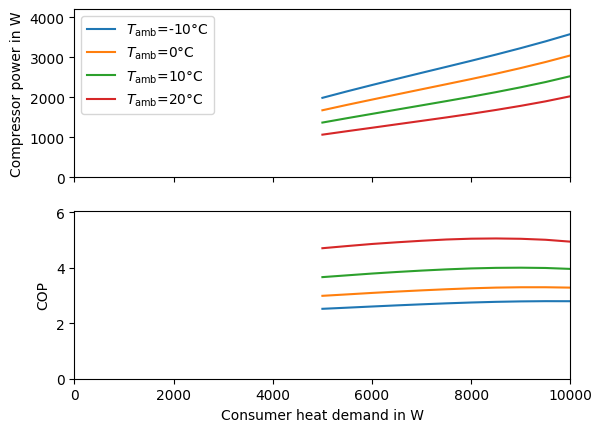

In [39]:
power_max = 0
COP_max = 0

fig, ax = plt.subplots(2, sharex=True)

for temp in [-10, 0, 10, 20]:

    ax[0].plot(np.abs(results[temp].index), results[temp]["compressor-power"], label="$T_\\mathrm{amb}$=" + str(temp) + "°C")
    ax[1].plot(np.abs(results[temp].index), results[temp]["COP"])
    COP_max = max(results[temp]["COP"].max(), COP_max)
    power_max = max(results[temp]["compressor-power"].max(), power_max)

ax[0].legend()
ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, power_max * 1.05])
ax[1].set_ylabel("COP")
ax[1].set_ylim([0, COP_max + 1])
ax[1].set_xlim([0, abs(Q_design)])
_ = ax[1].set_xlabel("Consumer heat demand in W")

In [162]:
def quad_regr(x, y, y0, degree):

    X = np.zeros((x.shape[0], degree))
    for i in range(x.shape[0]):
        for j in range(degree):
            X[i, j] = x[i] ** j

    mat_S = X.T.dot(X)
    vek_t = X.transpose().dot(y)

    if y0 is None:
        result = np.linalg.inv(mat_S).dot(vek_t)
    else:
        A = np.array([[1 if _ == 0 else 0 for _ in range(degree)]])
        A_T = np.array([[1] if _ == 0 else [0] for _ in range(degree + 1)])
        mat_S_NB = np.concatenate((2 * mat_S, A))
        mat_S_NB = np.concatenate((mat_S_NB, A_T), axis=1)
        vek_t_NB = np.concatenate((2 * vek_t, np.array([y0])))
        result = np.linalg.inv(mat_S_NB).dot(vek_t_NB)

    return result

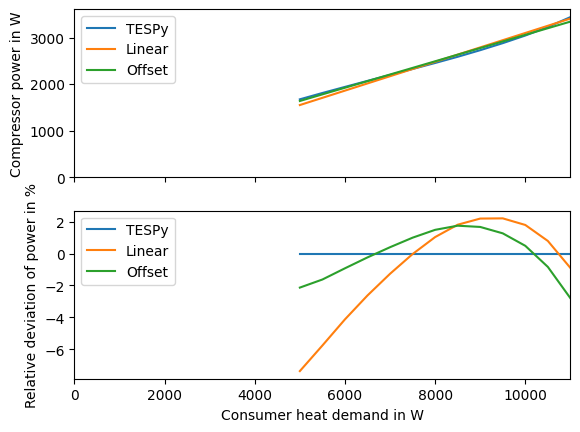

In [210]:
temp = 0

x = -results[temp].index.values.astype(float)
y = results[temp]["compressor-power"].values.astype(float)
yy_tespy = y

f = quad_regr(x, y, 0, 2)
yy_linear = f[0] + f[1] * x

fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(x, yy_tespy, label="TESPy")
ax[0].plot(x, yy_linear, label="Linear")

f = quad_regr(x, y, None, 2)
yy_offset = f[0] + f[1] * x
ax[0].plot(x, yy_offset, label="Offset")

ax[1].plot(x, (yy_tespy - yy_tespy) / yy_tespy * 100, label="TESPy")
ax[1].plot(x, (yy_linear - yy_tespy) / yy_tespy * 100, label="Linear")
ax[1].plot(x, (yy_offset - yy_tespy) / yy_tespy * 100, label="Offset")

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel("Compressor power in W")
ax[0].set_ylim([0, y.max() * 1.05])
ax[1].set_ylabel("Relative deviation of power in %")
ax[1].set_xlim([0, x.max()])
_ = ax[1].set_xlabel("Consumer heat demand in W")